# OpenAI Gym (DQN_train)
https://simoninithomas.github.io/Deep_reinforcement_learning_Course/  
https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8  
https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682  
https://github.com/yandexdataschool/Practical_RL/blob/master/week4_approx_rl/homework_pytorch.ipynb  
http://maciejjaskowski.github.io/2016/03/09/space-invaders.html  
https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

## 1. Setup

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import retro
import sys
import tensorflow as tf

from collections import deque
from dqn import DQN
from params import *
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')
print(f'retro.version: {retro.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0
retro.version: 0.6.1.dev25+g9ec2e44


## 2. Look at the SpaceInvaders-Atari2600 env
Steps to follow:
1. Download zip file from http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html
2. Open Roms.rar > ROMS.rar and find Space Invaders (1980) XXXXXX
3. Extract all matches (there are 5 of them) into your destin folder
4. python -m retro.import . (don't forget the point)

In [2]:
env = retro.make('SpaceInvaders-Atari2600')
env.reset()
env.render()
print(f'action_space.size: {env.action_space.n}')

action_space.size: 8


In [3]:
actions = np.identity(env.action_space.n, dtype=int)
for a in actions:
    print(a, ': ', env.get_action_meaning(a))

[1 0 0 0 0 0 0 0] :  ['BUTTON']
[0 1 0 0 0 0 0 0] :  []
[0 0 1 0 0 0 0 0] :  []
[0 0 0 1 0 0 0 0] :  []
[0 0 0 0 1 0 0 0] :  ['UP']
[0 0 0 0 0 1 0 0] :  ['DOWN']
[0 0 0 0 0 0 1 0] :  ['LEFT']
[0 0 0 0 0 0 0 1] :  ['RIGHT']


__I will use just 4 actions: [0, 1, 6, 7] <=> ['BUTTON', '', 'LEFT', 'RIGHT']__

## 3. DQN

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ELU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ELU)  
3. Conv2d(filters=64, kernel_size=3, strides=2, padding='valid', activation=ELU) -> Flatten()  
4. FC(512, activation=ELU)
5. FC(NUM_ACTIONS, activation=Linear)

### Instantiate DQNs: DQN and TargetDQN

In [4]:
tf.reset_default_graph()

dqn = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQN')
dqn_target = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQNTarget')

## 4. Training

### Memory class (for Experience Replay)

In [5]:
class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        indices = np.random.choice(np.arange(buffer_size),
                                   size=batch_size,
                                   replace=False)
        experiences_batch = [self.buffer[idx] for idx in indices]
        return experiences_batch

#### Pre-populate memory by taking random actions and storing each experience (state, action, reward, next_state, done)

In [6]:
def get_pre_populated_memory(env):
    memory = Memory(max_size=MEMORY_SIZE)
    stacked_frames = []
    state = None

    for step in range(PRETRAIN_LENGTH):
        if step == 0:
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)

        # random action
        action_idx = np.random.randint(ACTION_SIZE)
        action = POSSIBLE_ACTIONS[action_idx]
        
        # next state
        next_state, reward, done, _ = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                  is_new_episode=False)

        if done:
            # the end of episode (next_state = 0)
            next_state = np.zeros(STATE_SHAPE)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                      is_new_episode=False)

            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))

            # start a new episode
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
        else:
            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))
            state = next_state
    
    return memory

### Helper function to copy DQN parameters to DQNTarget

In [7]:
def update_dqn_target():
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQN')
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQNTarget')
    
    op_holder = []
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
        
    return op_holder

### DQN (training algorithm)

In [8]:
def eps_greedy(sess, state, eps_decay_step):
    # eps: exploration probability
    eps = EPS_END + (EPS_START - EPS_END) * np.exp(-EPS_DECAY_RATE * eps_decay_step)
    
    if np.random.rand() < eps:
        # exploration with eps probability
        action_idx = np.random.randint(ACTION_SIZE)
    else:
        # exploitation with (1 - eps) probability
        Q = sess.run(dqn.output,
                     feed_dict={
                         dqn.input_ph: state.reshape(1, *STATE_SHAPE)
                     })
        
        action_idx = np.argmax(Q)

    return action_idx, eps

In [9]:
def dqn_training(dqn, dqn_target,
                 num_episodes=NUM_EPISODES, 
                 max_steps_per_episode=MAX_STEPS_PER_EPISODE, 
                 batch_size=BATCH_SIZE,
                 learning_rate=LEARNING_RATE):
    
    # memory for experience replay
    memory = get_pre_populated_memory(env)
    
    # update dqn target op
    update_dqn_target_op = update_dqn_target()    
    
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=30)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # init dqn_target with the same params as dqn
        sess.run(update_dqn_target_op)
        
        step = 0
        best_rewards = [0 for _ in range(2)]
        best_episodes = [[] for _ in range(2)]
        iters_per_episode = []
        reward_per_episode = []
        loss_per_iter = []
        
        for episode in range(1, num_episodes + 1):
            episode_step = 0
            done = False
            stacked_frames = []
            episode_rewards = []
            episode_states = []
            
            # new episode
            state = env.reset()
            episode_states.append(state.copy())
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
            
            
            while (not done) and (episode_step < max_steps_per_episode):
                episode_step += 1
                step += 1
                
                action_idx, eps = eps_greedy(sess, state, step)
                action = POSSIBLE_ACTIONS[action_idx]
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                episode_states.append(next_state.copy())
                
                if done:
                    # the end of episode (next_state = 0)
                    next_state = np.zeros(STATE_SHAPE)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Epsilon: {eps}')
                else:
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    state = next_state
                    
                ### learning part ###
                # sample a random batch of experiences from memory
                batch = memory.sample(batch_size)
                batch_states = np.array([experience[0] for experience in batch], ndmin=3)
                batch_action_indices = np.array([experience[1] for experience in batch])
                batch_rewards = np.array([experience[2] for experience in batch])
                batch_next_states = np.array([experience[3] for experience in batch], ndmin=3)
                batch_dones = np.array([experience[4] for experience in batch])

                # if the episode ends at next_state:
                #     Q_target(state) = reward
                # else:
                #     Q_target(state) = reward + gamma * argmax(a){Q_next_state}
                Q_batch_next_state = sess.run(dqn_target.output,
                                              feed_dict={
                                                  dqn_target.input_ph: batch_next_states
                                              })
                
                # terminal states => Q value = 0
                Q_batch_next_state[batch_dones, :] = 0
                
                Q_target = batch_rewards + GAMMA * np.max(Q_batch_next_state, axis=1)
                
                loss, _ = sess.run([dqn.loss, dqn.optimization_step],
                                   feed_dict={
                                       dqn.input_ph: batch_states,
                                       dqn.action_indices_ph: batch_action_indices,
                                       dqn.Q_target_ph: Q_target,
                                       dqn.learning_rate_ph: learning_rate
                                   })
                
                if step % Q_TARGET_UPDATE_FREQ == 0:
                    print('Update parameters of DQNTarget')
                    sess.run(update_dqn_target_op)
                
                loss_per_iter.append(loss)
            
            # keep 2 train episodes with high reward
            min_pos = np.argmin(best_rewards)
            max_pos = np.argmax(best_rewards)
            min_reward = best_rewards[min_pos]
            max_reward = best_rewards[max_pos]
            cur_reward = reward_per_episode[-1]
            
            if cur_reward > max_reward:
                best_episodes[min_pos] = best_episodes[max_pos]
                best_rewards[min_pos] = best_rewards[max_pos]
                best_episodes[max_pos] = [episode, cur_reward, episode_states]
                best_rewards[max_pos] = cur_reward
            elif cur_reward > min_reward:
                best_episodes[min_pos] = [episode, cur_reward, episode_states]
                best_rewards[min_pos] = cur_reward
            
            if (episode == 1) or (episode % SAVE_EVERY == 0):
                saver.save(sess, f'{SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, loss_per_iter, best_episodes

In [10]:
%%time
!rm -rf $SAVE_PATH
train_stats = dqn_training(dqn, dqn_target, num_episodes=NUM_EPISODES)

Episode: 1, Total reward: 110.0, Epsilon: 0.9576497226762632
Model saved
Episode: 2, Total reward: 225.0, Epsilon: 0.9097751899061124
Model saved
Episode: 3, Total reward: 155.0, Epsilon: 0.877959403259865
Model saved
CPU times: user 5min 5s, sys: 5min 20s, total: 10min 25s
Wall time: 3min 28s


#### Training stats

In [11]:
iters_per_episode, reward_per_episode, loss_per_iter, best_episodes = train_stats

#### Save episodes with high reward during training phase (max 2)

In [12]:
!rm -rf ./train_stats
!mkdir ./train_stats

In [13]:
%%time
for episode, reward, frames in best_episodes:
    np.save(f'./train_stats/train_episode_{episode}_reward_{int(reward)}.npy', frames)

CPU times: user 92 ms, sys: 380 ms, total: 472 ms
Wall time: 1.6 s


#### Some plots

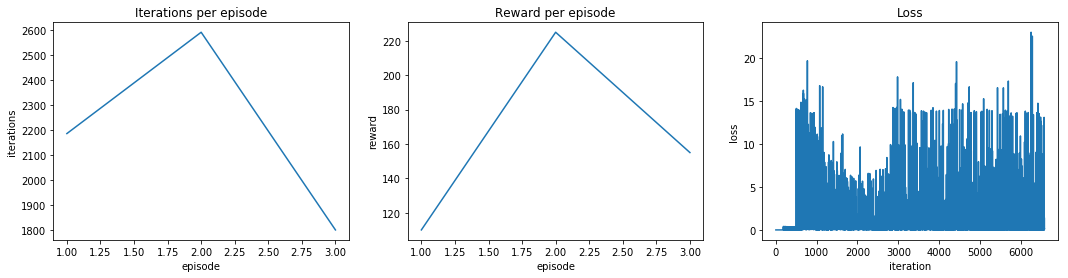

In [14]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(loss_per_iter)) + 1

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(1, 3, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(1, 3, 3)
plt.title('Loss')
plt.plot(iter_range, loss_per_iter)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()